In [1]:
import sys
import os
import anndata as ad
import pandas as pd
import scanpy as sc
import re
import numpy as np
import seaborn as sns; sns.set(color_codes=True)
import scimap as sm  
from matplotlib import pyplot as plt
from matplotlib.patches import Patch
from scipy.stats import pearsonr
import napari

Running SCIMAP  2.1.0


In [2]:
adata=ad.read(r"C:\Users\tav9\HMS Dropbox\Tuulia Vallius\PCA_phaseII\cycif_analysis_materials\data_e41\e41_mel27_cy8_04012025.h5ad")

C:\Users\tav9\AppData\Local\anaconda3\envs\scimap_new\lib\site-packages\anndata\__init__.py:55: FutureWarning:

`anndata.read` is deprecated, use `anndata.read_h5ad` instead. `ad.read` will be removed in mid 2024.



In [3]:
adata

AnnData object with n_obs × n_vars = 128060 × 33
    obs: 'X_centroid', 'Y_centroid', 'Area', 'MajorAxisLength', 'MinorAxisLength', 'Eccentricity', 'Solidity', 'Extent', 'Orientation', 'CellID', 'imageid', 'batch', 'ROI', 'LOSE', 'ROI_major_category', 'ROI_TV', 'phenotype', 'MEL_id', 'GeoMx_aoi', 'tumor_state'
    uns: 'all_markers'
    layers: 'combat', 'log', 'raw', 'rescaled'

In [8]:
#rename GeoMX regions to belong to the clusters within the correlation spanning tree

rename={'I':['LSP13914_006','LSP13914_007','LSP13914_012','LSP13914_009','LSP13914_008','LSP13914_011','LSP13914_005'],
'II':['LSP13914_014','LSP13918_027','LSP13918_049','LSP13918_043','LSP13914_017','LSP13918_029','LSP13914_015'],
'III':[],
'IV':['LSP13918_028','LSP13918_031','LSP13918_030'],
'V':['LSP13914_003'],
'VI':['LSP13918_010','LSP13918_009','LSP13918_011','LSP13918_050']}

adata = sm.hl.rename(adata, rename, from_column='GeoMx_aoi', to_column='CST_cluster_group')

Renaming LSP13914_006 to I
Renaming LSP13914_007 to I
Renaming LSP13914_012 to I
Renaming LSP13914_009 to I
Renaming LSP13914_008 to I
Renaming LSP13914_011 to I
Renaming LSP13914_005 to I
Renaming LSP13914_014 to II
Renaming LSP13918_027 to II
Renaming LSP13918_049 to II
Renaming LSP13918_043 to II
Renaming LSP13914_017 to II
Renaming LSP13918_029 to II
Renaming LSP13914_015 to II
Renaming LSP13918_028 to IV
Renaming LSP13918_031 to IV
Renaming LSP13918_030 to IV
Renaming LSP13914_003 to V
Renaming LSP13918_010 to VI
Renaming LSP13918_009 to VI
Renaming LSP13918_011 to VI
Renaming LSP13918_050 to VI


In [11]:
#define MART+/NGFR+/SOX9+ tumor states

sm.hl.classify(adata, pos=['NGFR'], neg=None, classify_label='NGFR+', phenotype='phenotype', 
               subclassify_phenotype='Melanocytes', threshold=0.5, collapse_failed=False, label='NGFRpos')
rename= {'NGFR+': ['NGFR+'],
        'NGFR-':['Melanocytes']}
adata = sm.hl.rename(adata, rename, from_column='NGFRpos', to_column='NGFRpos')

sm.hl.classify(adata, pos=['SOX9'], neg=None, classify_label='SOX9+', phenotype='phenotype', 
               subclassify_phenotype='Melanocytes', threshold=0.5, collapse_failed=False, label='SOX9pos')
rename= {'SOX9+': ['SOX9+'],
        'SOX9-':['Melanocytes']}
adata = sm.hl.rename(adata, rename, from_column='SOX9pos', to_column='SOX9pos')

sm.hl.classify(adata, pos=['MART1'], neg=None, classify_label='MART1+', phenotype='phenotype', 
               subclassify_phenotype='Melanocytes', threshold=0.5, collapse_failed=False, label='MART1pos')
rename= {'MART1+': ['MART1+'],
        'MART1-':['Melanocytes']}
adata = sm.hl.rename(adata, rename, from_column='MART1pos', to_column='MART1pos')

Renaming NGFR+ to NGFR+
Renaming Melanocytes to NGFR-
Renaming SOX9+ to SOX9+
Renaming Melanocytes to SOX9-
Renaming MART1+ to MART1+
Renaming Melanocytes to MART1-


In [12]:
adata.obs["tumor_state_v2"] = adata.obs[["MART1pos","NGFRpos"]].agg(" ".join, axis=1)

In [23]:
adata.obs["tumor_state_v3"].value_counts()

tumor_state_v3
Unknown Unknown Unknown                            67892
Keratinocytes Keratinocytes Keratinocytes          20379
Myeloid lineage Myeloid lineage Myeloid lineage    13256
Myofibroblasts Myofibroblasts Myofibroblasts       11517
MART1- NGFR- SOX9-                                  6197
MART1+ NGFR- SOX9-                                  4762
MART1- NGFR+ SOX9-                                  1660
MART1- NGFR- SOX9+                                  1153
MART1- NGFR+ SOX9+                                   874
MART1+ NGFR- SOX9+                                   340
MART1+ NGFR+ SOX9-                                    15
MART1+ NGFR+ SOX9+                                    15
Name: count, dtype: int64

In [22]:
adata.obs["tumor_state_v3"] = adata.obs[["tumor_state_v2","SOX9pos"]].agg(" ".join, axis=1)

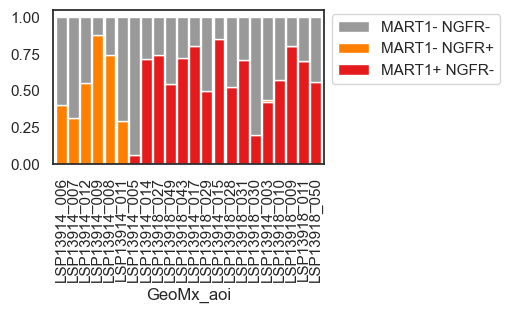

In [25]:
x=['LSP13914_006','LSP13914_007','LSP13914_012','LSP13914_009','LSP13914_008','LSP13914_011','LSP13914_005',
  'LSP13914_014','LSP13918_027','LSP13918_049','LSP13918_043','LSP13914_017','LSP13918_029','LSP13914_015',
  'LSP13918_028','LSP13918_031','LSP13918_030',
  'LSP13914_003',
  'LSP13918_010','LSP13918_009','LSP13918_011','LSP13918_050']

y=['MART1- NGFR+','MART1+ NGFR-','MART1- NGFR-']
b=sm.pl.stacked_barplot(adata, y_axis='tumor_state_v2', x_axis='GeoMx_aoi', 
                      subset_xaxis=x, subset_yaxis=y, order_xaxis=x, order_yaxis=None, 
                      method='percent', figsize=(3.5,2), return_data=True)

In [29]:
x=['LSP13914_006','LSP13914_007','LSP13914_012','LSP13914_009','LSP13914_008','LSP13914_011','LSP13914_005',
  'LSP13914_014','LSP13918_027','LSP13918_049','LSP13918_043','LSP13914_017','LSP13918_029','LSP13914_015',
  'LSP13918_028','LSP13918_031','LSP13918_030',
  'LSP13914_003',
  'LSP13918_010','LSP13918_009','LSP13918_011','LSP13918_050']

y=['MART1- NGFR- SOX9-','MART1+ NGFR- SOX9-','MART1- NGFR+ SOX9-','MART1- NGFR- SOX9+','MART1+ NGFR- SOX9+']
b=sm.pl.stacked_barplot(adata, y_axis='tumor_state_v3', x_axis='GeoMx_aoi', 
                      subset_xaxis=x, subset_yaxis=y, order_xaxis=x, order_yaxis=None, 
                      method='percent', figsize=(3.5,2), return_data=True,fileName="MEL27_tumor_state_geoMX_MR.pdf", saveDir=(r"C:\Users\tav9\HMS Dropbox\Tuulia Vallius\test\test"))

Saved plot to C:\Users\tav9\HMS Dropbox\Tuulia Vallius\test\test\MEL27_tumor_state_geoMX_MR.pdf
